In [7]:

import torch
import numpy as np

from src.visibility_utils import show
from src.utils import params_to_extrinsic
from src.model import extract_3d_from_pairs, prepare_data, fit

import plotly
import plotly.express as px
import plotly.graph_objs as go


def default_arguments():

    camera_angle_x = 0.6911112070083618
    width = 800
    height = 800

    # data paths
    imgs_path = "D:\\9.programming\\Plenoxels\\data\\lego\\test"
    matching_pairs = np.load("D:\\9.programming\\sfm\\matching_pairs_kornia.npy", allow_pickle=True)

    return camera_angle_x, width, height, imgs_path, matching_pairs


def default_arguments2():

    camera_angle_x = 0.6911112070083618
    width = 400
    height = 800

    # data paths
    imgs_path = "D:\\9.programming\\sfm\\vid\\statue_frames"
    matching_pairs = np.load("D:\\9.programming\\sfm\\matching_pairs_statue_kornia.npy", allow_pickle=True)

    return camera_angle_x, width, height, imgs_path, matching_pairs


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# camera parameters
camera_angle_x, width, height, imgs_path, matching_pairs = default_arguments()

for i, pair in enumerate(matching_pairs):
    matching_pairs[i]['0']['points'][:, 1] = height - pair['0']['points'][:, 1]
    matching_pairs[i]['1']['points'][:, 1] = height - pair['1']['points'][:, 1]

# Compute focal length

camera_angle_x = torch.tensor([camera_angle_x])
f = width / (2 * torch.tan(camera_angle_x / 2))

# Construct the camera matrix K
K = torch.tensor([
    [f, 0, width / 2],
    [0, f, height / 2],
    [0, 0, 1]
]).unsqueeze(0).type(torch.float32).to("cpu")

# ---

camera_views, visibility_matrix = extract_3d_from_pairs(matching_pairs, imgs_path, height, K)

camera_extrinsic = torch.cat([c["extrinsic"] for c in camera_views])
camera_intrinsic = torch.cat([c["intrinsic"] for c in camera_views])
batch_visibility, batch_point3d, batch_point2d, batch_colors = prepare_data(
    camera_views[:],
    visibility_matrix,
    filter_visible=3
)

points_3d = torch.stack([p.mean(dim=0) for p in batch_point3d])
colors = torch.stack([p.type(torch.float32).mean(dim=0) for p in batch_colors])

labels = [batch_point2d[batch_visibility[:, index], index].to(device) for index in range(batch_visibility.shape[1])]

# remove cameras with no relevant points
cameras_with_points_indices = torch.tensor([len(l) for l in labels]).greater(0)
camera_extrinsic = camera_extrinsic[cameras_with_points_indices]
camera_intrinsic = camera_intrinsic[cameras_with_points_indices]
batch_visibility = batch_visibility[:, cameras_with_points_indices]
labels = [l for l in labels if len(l) > 0]

model, lossgraph = fit(
    camera_extrinsic,
    camera_intrinsic,
    labels,
    points_3d,
    batch_visibility,
    width=width, 
    height=height,
    steps=4500,
    lr=0.005,
    # train_angle=True,
    train_angle=False,
    camera_indecies_to_train=[],
    fit_cam_only=False,
    device=device
)

# visualize
fig = px.line(x=torch.arange(len(lossgraph)), y=lossgraph, title="training loss")
fig.show()

  0%|          | 0/39 [00:00<?, ?it/s]

loss: 0.5993: 100%|██████████| 4500/4500 [02:56<00:00, 25.51it/s]


In [9]:
model.camera_angle_x

Parameter containing:
tensor([0.6911], device='cuda:0', requires_grad=True)

In [10]:
with torch.inference_mode():
    r_display = [r for r in params_to_extrinsic(model.extrinsics_params)[:, :-1, :3].squeeze().clone().detach().cpu()]
    t_display = [t for t in params_to_extrinsic(model.extrinsics_params)[:, :-1, 3:].squeeze().clone().detach().cpu()]
    points3d_model = model.points3d.clone().detach().cpu().numpy()

show(r_display, t_display, points3d_model[:], colors[:], onlypoints=True)

In [11]:
show(r_display, t_display, points3d_model[:0], colors, onlypoints=False)

0


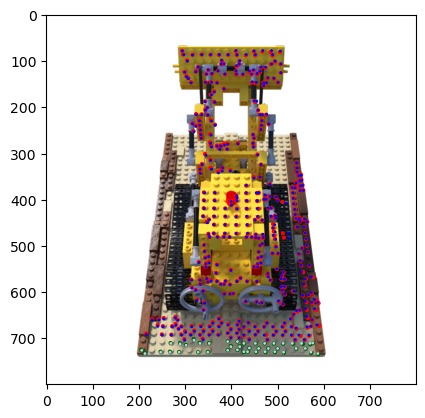

1


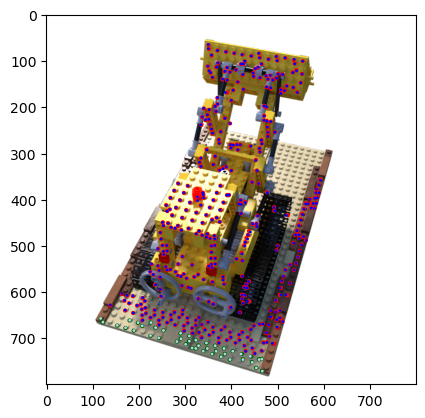

2


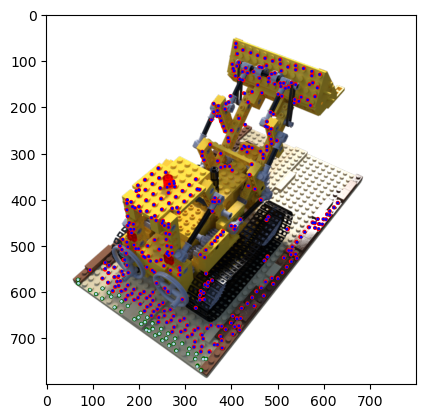

3


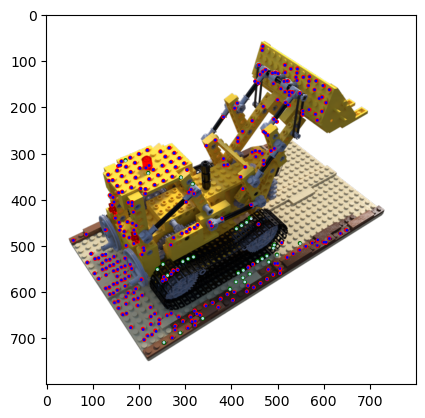

4


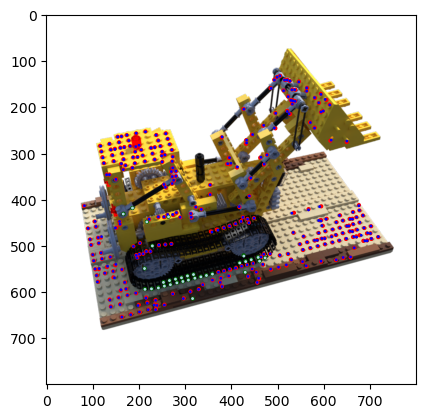

5


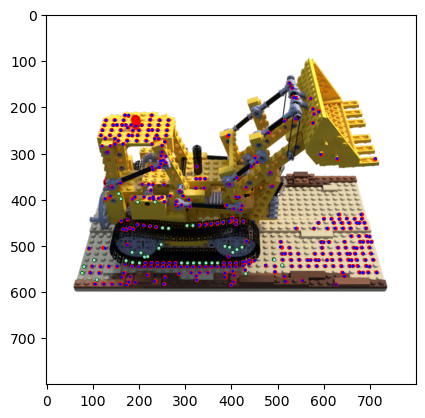

6


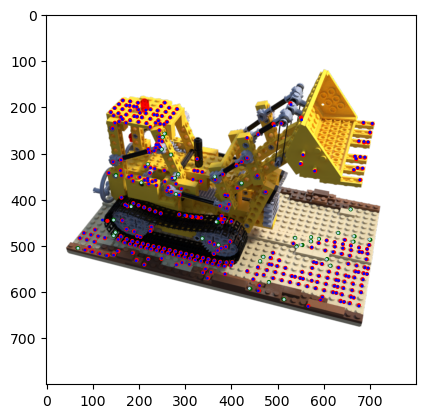

7


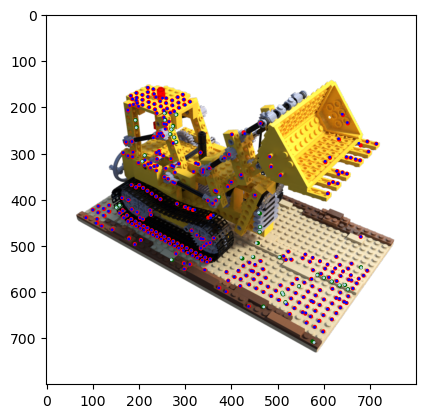

8


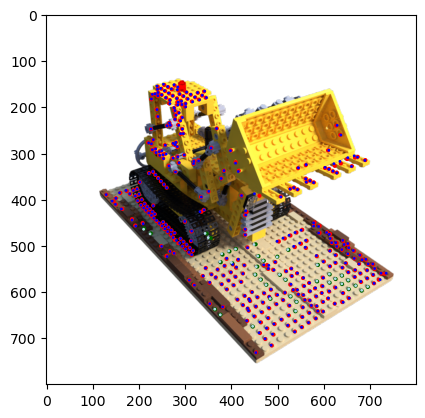

9


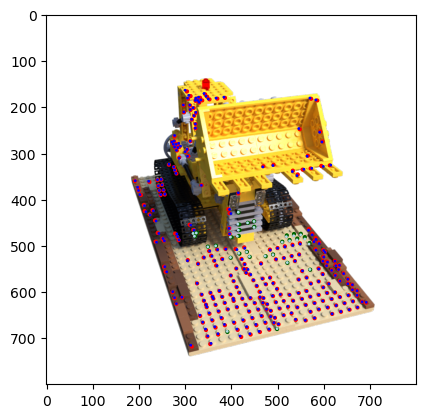

10


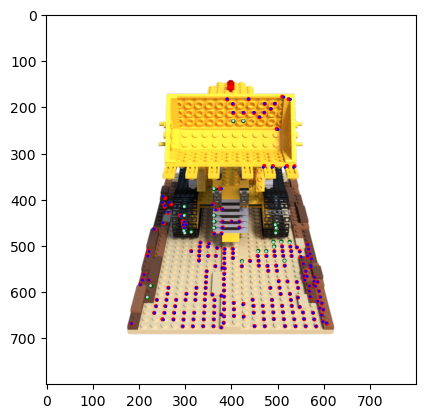

11


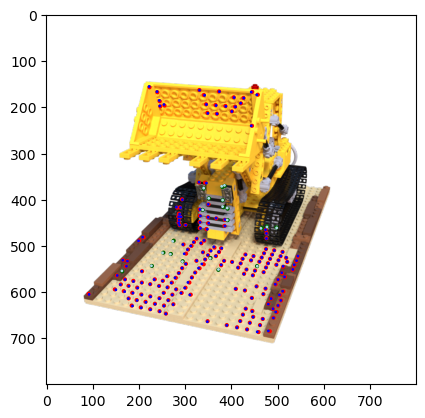

12


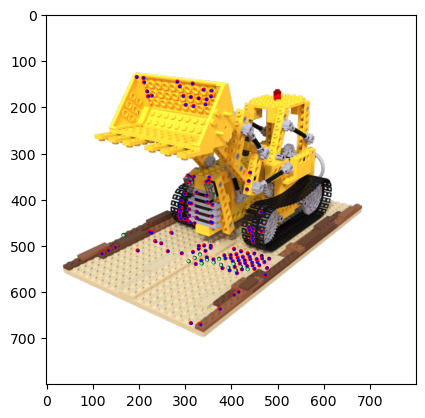

13


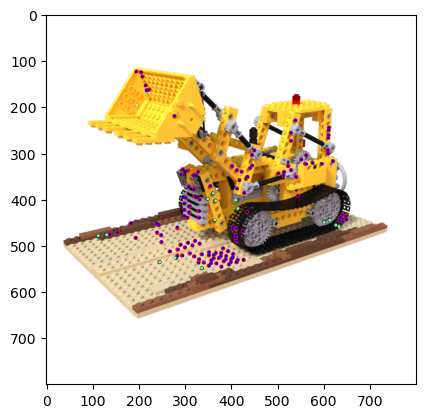

14


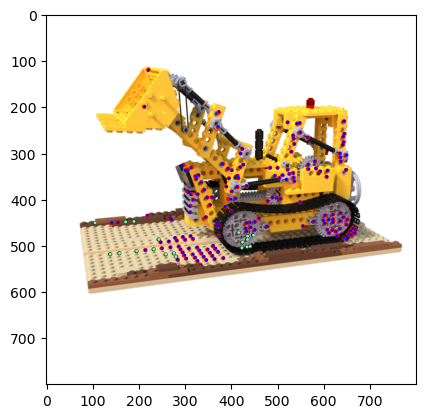

15


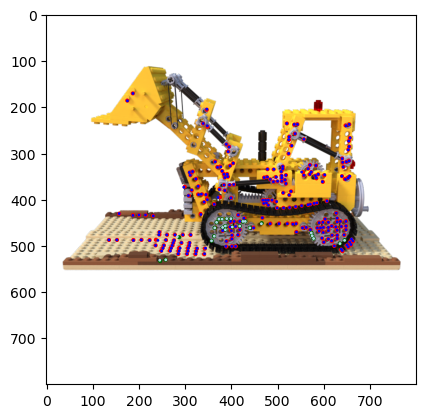

16


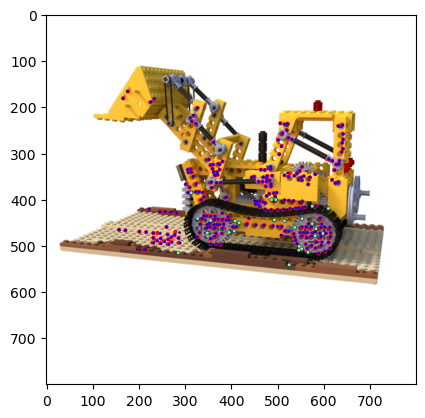

17


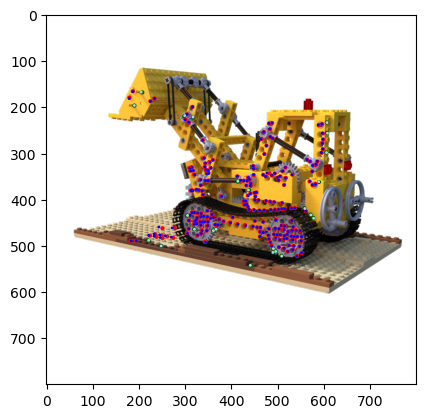

18


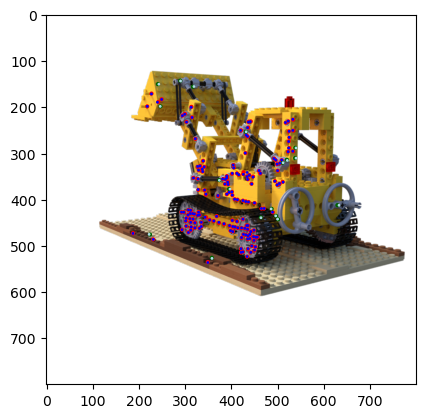

19


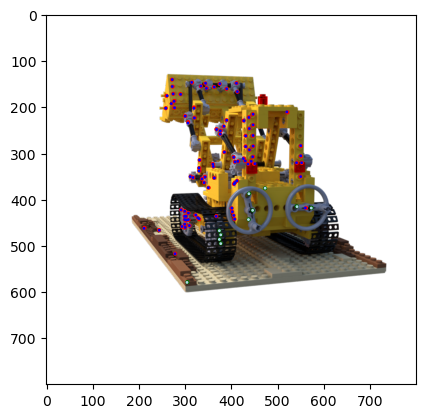

20


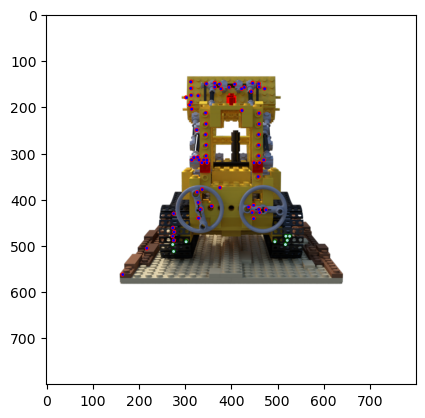

21


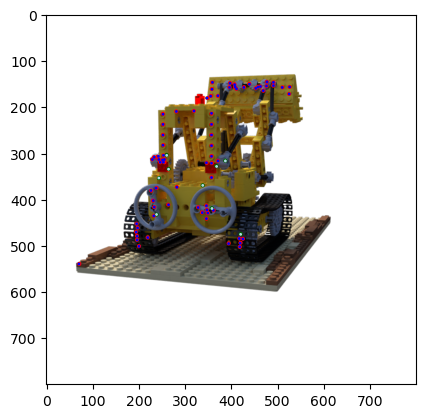

22


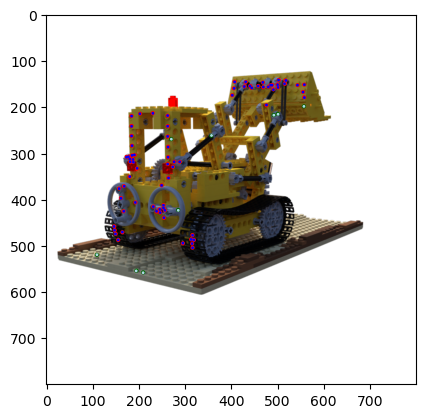

23


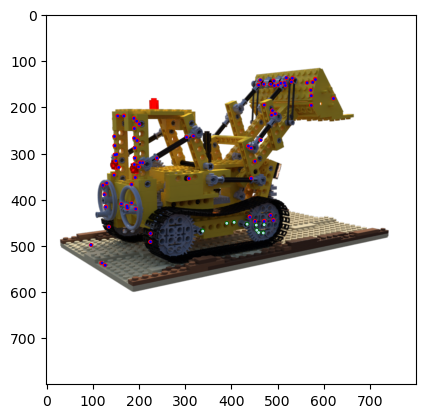

24


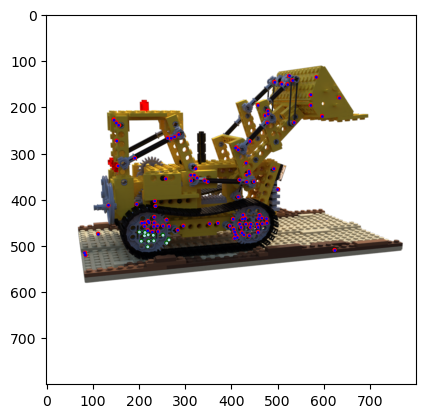

25


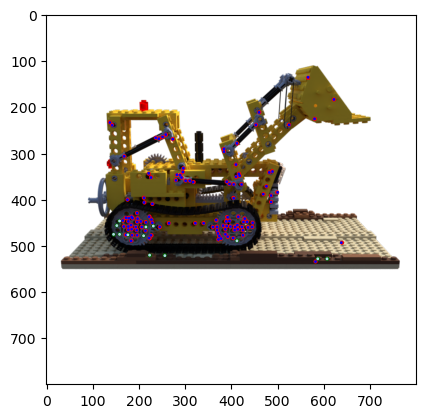

26


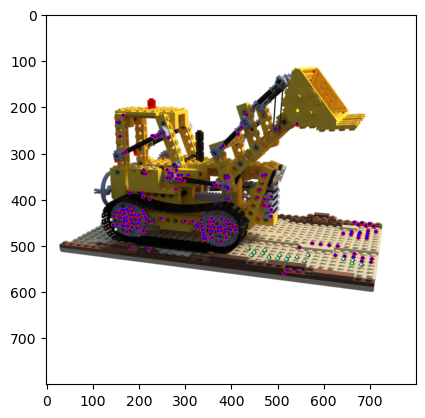

27


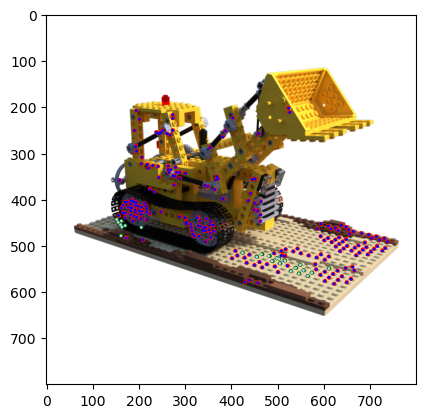

28


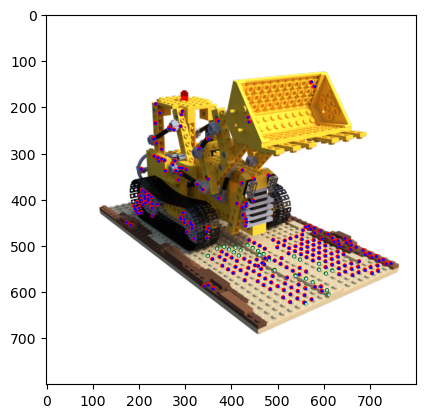

29


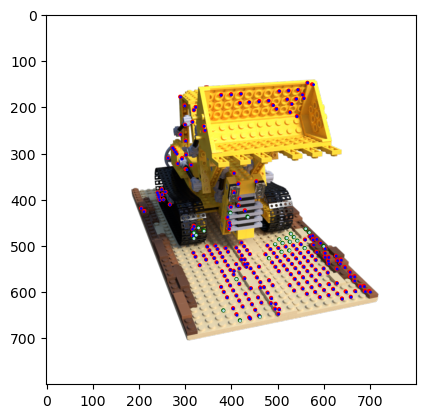

30


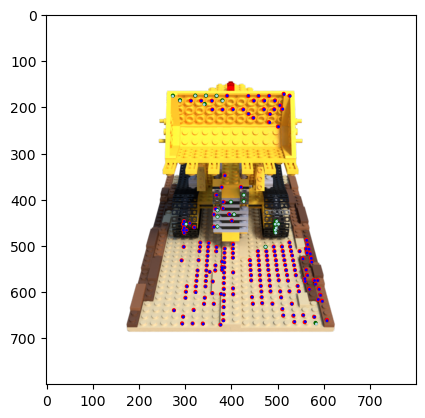

31


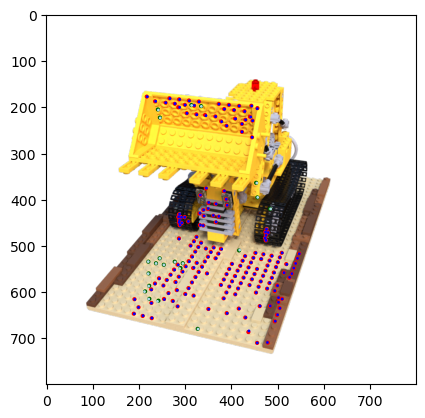

32


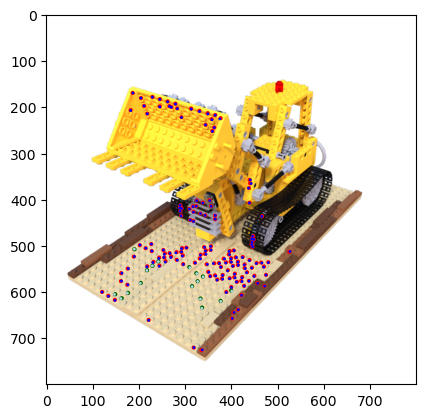

33


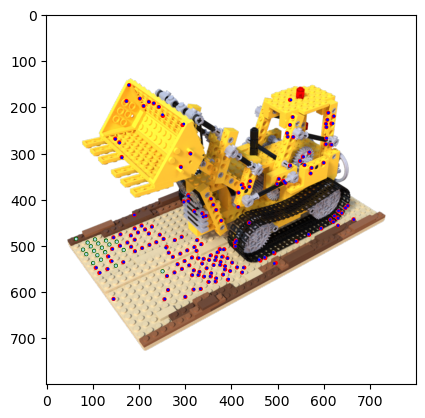

34


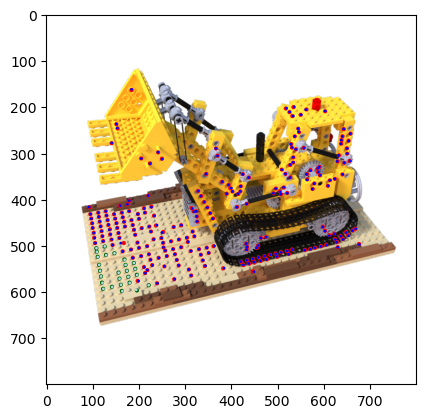

35


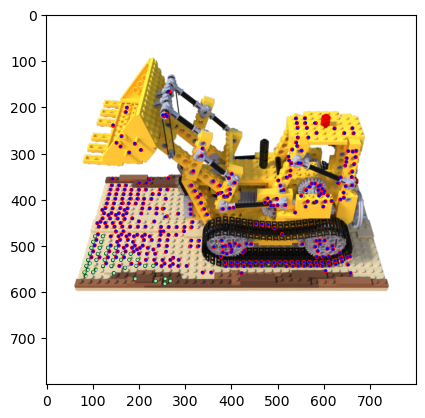

36


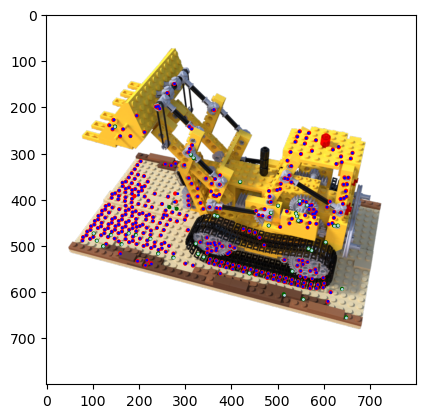

37


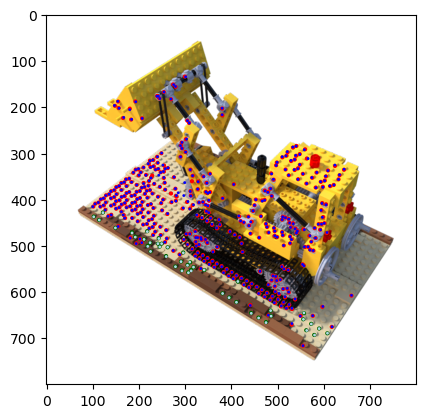

38


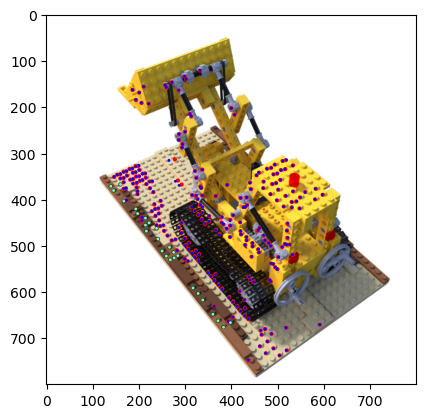

39


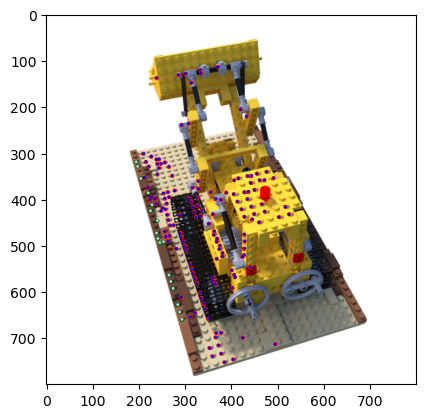

In [12]:
import os
from matplotlib import pyplot as plt
from src.utils import project_2d_to_3d, params_to_extrinsic

img_paths = [matching_pairs[0]['0']['name']] + [p['1']['name'] for p in matching_pairs]

model.eval()

with torch.inference_mode():
    extrinsics = params_to_extrinsic(model.extrinsics_params)
    intrinsics = model.get_intrinsics()
    p = model.forward()

    for index in range(len(camera_views)):

        print(index)        
        
        pp = p[index].detach().cpu()
        label = labels[index].detach().cpu()

        plt.imshow(plt.imread(img_paths[index]))
        plt.scatter(pp[:, 0], height - pp[ :, 1], s=4, c=["red"]*(int(pp.shape[0]*0.9)) + ["darkgreen"]*(pp.shape[0] - int(pp.shape[0]*0.9)))
        plt.scatter(label[:, 0], height - label[:, 1], s=1, c=["blue"]*(int(pp.shape[0]*0.9)) + ["lightblue"]*(label.shape[0] - int(label.shape[0]*0.9)))
        plt.show()
